In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


In [2]:
from importlib import reload
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
from tqdm.auto import tqdm, trange
import mmcv
import data
import bbox
from utils import imshownp
import utils
import meva
from meva.lib.meva_model import MEVA
from meva.utils import kp_utils
from meva.utils import image_utils
from meva.utils.video_config import update_cfg
from torch.utils.data import DataLoader
import joblib
import scipy

/home/tormod/Documents/APEC/meva/utils/transformations.py:1927: UserWarning: No module named 'meva.utils._transformations'
  warnings.warn(str(err))


In [48]:
from importlib import reload
reload(data)

<module 'data' from '/home/tormod/Documents/APEC/data.py'>

In [9]:
c = data.ClimbingDataset('all', seq_len=30)#, preload_all=True)

In [44]:
l = list(map(lambda s: s['features'].shape[0], c))

29

In [45]:
np.array(l).argmin()

4905

In [63]:
len(c.vids[-1])/30

248.03333333333333

In [52]:
c[4905]['features'].shape

torch.Size([29, 2048])

In [56]:
c[4905]

{'raw_imgs': [],
 'norm_imgs': [],
 'features': tensor([[0.0350, 0.0000, 0.0058,  ..., 0.0103, 0.0000, 0.0014],
         [0.0364, 0.0000, 0.0076,  ..., 0.0100, 0.0002, 0.0032],
         [0.0363, 0.0001, 0.0071,  ..., 0.0087, 0.0002, 0.0045],
         ...,
         [0.0246, 0.0208, 0.0011,  ..., 0.0025, 0.0000, 0.0000],
         [0.0211, 0.0145, 0.0018,  ..., 0.0021, 0.0000, 0.0000],
         [0.0264, 0.0300, 0.0011,  ..., 0.0043, 0.0000, 0.0000]]),
 'raw_kp_2d': array([[[4.2740161e+02, 4.1777124e+02, 7.6444882e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [5.8454303e+02, 3.9124802e+02, 8.9196950e-01],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
 
        [[4.3834930e+02, 4.3025891e+02, 6.9331199e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [5.8647778e+02, 3.9948727e+02, 8.8737249e-01],
         ...,

In [9]:
pretrained_file = f"results/meva/train_meva_2/model_best.pth.tar"
config_file = f"meva/cfg/train_meva_2.yml"
cfg = update_cfg(config_file)

In [8]:
batch_size = 6
model = MEVA(
    n_layers=cfg.MODEL.TGRU.NUM_LAYERS,
    batch_size=batch_size,
    seqlen=cfg.DATASET.SEQLEN,
    hidden_size=cfg.MODEL.TGRU.HIDDEN_SIZE,
    add_linear=cfg.MODEL.TGRU.ADD_LINEAR,
    bidirectional=cfg.MODEL.TGRU.BIDIRECTIONAL,
    use_residual=cfg.MODEL.TGRU.RESIDUAL,
    cfg=cfg.VAE_CFG,
)
ckpt = torch.load(pretrained_file, map_location='cpu')
# print(f'Performance of pretrained model on 3DPW: {ckpt["performance"]}')
ckpt = ckpt['gen_state_dict']
model.load_state_dict(ckpt)
model.eval()

loading VAErecV2 model from checkpoint: results/meva/vae_rec_2/models/model_1000.p


MEVA(
  (vae_model): VAErecV2(
    (e_rnn): RNN(
      (rnn_f): GRUCell(144, 256)
      (rnn_b): GRUCell(144, 256)
    )
    (e_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (e_mu): Linear(in_features=512, out_features=512, bias=True)
    (e_logvar): Linear(in_features=512, out_features=512, bias=True)
    (d_rnn): RNN(
      (rnn_f): GRUCell(656, 512)
    )
    (d_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (d_out): Linear(in_features=512, out_features=144, bias=True)
    (init_pose_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (init_p

In [27]:
batch_size=6
dataloader = DataLoader(c, batch_size=batch_size, num_workers=8, shuffle = False)

In [36]:
import time
output = {}
pred_cam, pred_verts, pred_pose, pred_betas, pred_joints3d, norm_joints2d = [], [], [], [], [], []
for seqs in dataloader.batch_sampler:
    with torch.no_grad():
        start = time.time()
        feats = torch.stack([torch.Tensor(seq['features']) for seq in seqs])
        output = model(feats)[-1]
        finish = time.time()
        pred_cam.append(output['theta'][:, :, :3])
        pred_verts.append(output['verts'])
        pred_pose.append(output['theta'][:, :, 3:75])
        pred_betas.append(output['theta'][:, :, 75:])
        pred_joints3d.append(output['kp_3d'])
        norm_joints2d.append(output['kp_2d'])
    break
pred_cam = torch.cat(pred_cam, dim=0)
pred_verts = torch.cat(pred_verts, dim=0)
pred_pose = torch.cat(pred_pose, dim=0)
pred_betas = torch.cat(pred_betas, dim=0)
pred_joints3d = torch.cat(pred_joints3d, dim=0)
norm_joints2d = torch.cat(norm_joints2d, dim=0)

pred_cam = pred_cam.cpu().numpy()
pred_verts = pred_verts.cpu().numpy()
pred_pose = pred_pose.cpu().numpy()
pred_betas = pred_betas.cpu().numpy()
pred_joints3d = pred_joints3d.cpu().numpy()
norm_joints2d = norm_joints2d.cpu().numpy()
output_dict = {'pred_cam': pred_cam,
               'verts': pred_verts,
               'pose': pred_pose,
               'betas': pred_betas,
               'joints3d': pred_joints3d,
               'joints2d': norm_joints2d}

In [74]:
(finish-start)*len(c)/batch_size

2.7524242401123047

In [38]:
seqidx = 2
frameid = 20
seqinfo = c.get(seqidx)

/home/tormod/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


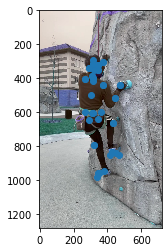

In [39]:
inv_trans = seqinfo['inv_trans'][frameid].copy()
kp_2d = norm_joints2d[seqidx, frameid].copy()
kp_2d *= 1.2
kp_2d = image_utils.normalize_2d_kp(kp_2d, inv=True)
kp_2d = image_utils.trans_points2d(kp_2d, inv_trans)
plt.imshow(seqinfo['raw_imgs'][frameid])
plt.scatter(kp_2d[:,0], kp_2d[:,1])
plt.show();

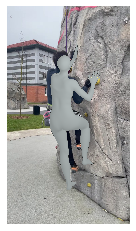

In [43]:
import mesh
verts = pred_verts[seqidx, frameid].copy()
cam = pred_cam[seqidx, frameid].copy()
bboxes = seqinfo['bboxes'].copy()
img = seqinfo['raw_imgs'][frameid].copy()
cam[0] *= 1.2*1.2
imshownp(mesh.render_pred_mesh(img, bboxes, verts, cam), bgr=True)

Total pretrained runtime on TITAN X was 42 seconds

# Render Results

In [44]:
from meva.utils.renderer import Renderer
from meva.utils.demo_utils import convert_crop_cam_to_orig_img
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
def render_vids(cd, res, out_folder, vid_idx):
    vid = cd.vids[vid_idx]
    vid_name = data.stripped_names[vid_idx]
    cd.load_labels(vid_name)
    bboxes = cd.bboxes[vid_name]
    orig_width, orig_height = vid.resolution
    renderer = Renderer(resolution=(orig_width, orig_height), orig_img=True)
    vertss = res['verts']
    vertss = vertss.reshape(-1, vertss.shape[-2], vertss.shape[-1])
    pred_cams = res['pred_cam']
    pred_cams = pred_cams.reshape(-1, pred_cams.shape[-1])
    for frame in trange(len(vertss)):
        img = vid[frame]
        verts = vertss[frame]
        pred_cam = pred_cams[np.newaxis, frame].copy()
        pred_cam[:, 0] *= 1.2*1.2
        bbox = bboxes[np.newaxis, frame]
        orig_cam = convert_crop_cam_to_orig_img(
            pred_cam, bbox, orig_width, orig_height)[0]
        mesh_img = renderer.render(img, verts, orig_cam)
        
        black_img = renderer.render(np.zeros_like(img), verts, orig_cam)  
        
        out_img = np.concatenate([black_img, mesh_img], axis=1)
        mmcv.imwrite(out_img, f'{out_folder}/{vid_name}/{frame:06d}.png')

    mmcv.frames2video(f'{out_folder}/{vid_name}', f'{out_folder}/{vid_name}.mp4',
                      filename_tmpl='{:06d}.png')

In [4]:
in_folder = '/home/tormod/ucph-erda-home/pretrained_meva_results'
out_folder = '/media/tormod/Den Lille/Thesis/pretrained_meva_results'
vid_idx = 0
vid_name = data.stripped_names[vid_idx]
res = joblib.load(f'{in_folder}/{vid_name}.pkl')

In [5]:
res.keys()

dict_keys(['pred_cam', 'verts', 'pose', 'betas', 'joints3d', 'joints2d'])

In [13]:
vid_folder = '/media/tormod/Den Lille/Thesis/videos'
cd = data.ClimbingDataset('all', video_folder=vid_folder)

In [45]:
render_vids(cd, res, out_folder, vid_idx)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6750/6750, 30.9 task/s, elapsed: 218s, ETA:     0s


# Eval Results

In [50]:
in_folder = '/home/tormod/ucph-erda-home/pretrained_meva_results'
def eval_res(split):
    cd = data.ClimbingDataset(split, preload_all=True)
    current_vid_name = ''
    res = []
    scores = []
    for seqidx, seq_info in tqdm(enumerate(cd)):
        inv_trans = seq_info['inv_trans']
        vid_idx = seq_info['vid_idx']
        vid_name = data.stripped_names[vid_idx]
        if vid_name != current_vid_name:
            res = joblib.load(f'{in_folder}/{vid_name}.pkl')
            current_vid_name = vid_name
        scales = seq_info['bboxes'][:,-1]
        frames = seq_info['frames']
        pred_seq = res['joints2d'][seqidx].copy()
        gt_seq = seq_info['kp_2d'].numpy()
        oks_score = utils.oks(pred_seq, gt_seq, scales, inv_trans)
        scores.append(oks_score)
    scores = np.stack(scores)
    scores = scores.reshape(-1, scores.shape[-1])
    # delete values for eye joints
    scores = np.delete(scores, 1, 1)
    scores = np.delete(scores, 1, 1)
    return scores

In [53]:
oks_testval = eval_res('testval')

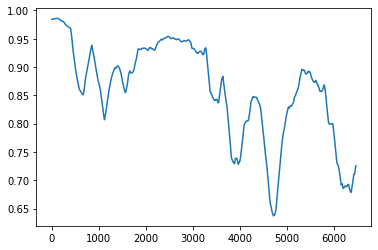

In [57]:
conv_N = 3*90
smooth_oks_testval = scipy.ndimage.convolve(oks_testval, np.ones((conv_N, 1))/conv_N, mode='mirror')
plt.plot(smooth_oks_testval.mean(axis=1))

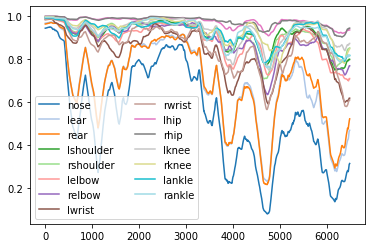

In [61]:
colors = cm.tab20(np.linspace(0,1,15))

coco_joint_names = kp_utils.get_coco_joint_names()
coco_joint_names = coco_joint_names[:1] + coco_joint_names[3:]

conv_N = 3*90

for j in range(oks_testval.shape[1]):
    j_oks = oks_testval[:,j].copy()
    j_oks = scipy.ndimage.convolve(j_oks, np.ones(conv_N)/conv_N, mode='mirror')
    plt.plot(j_oks, label=coco_joint_names[j], color=colors[j])
plt.legend(loc='lower left', ncol=2)